# ESTIMACIÓN DE PROBABILIDADES DE INCUMPLIMIENTO EN EL TIEMPO

In [1]:
#La obtención de probabilidades de incumplimiento es una parte fundamental en la toma de decisiones en las instituciones de crédito. La probabilidad de incumplimiento se define en general como la probabilidad de que un acreditado no cumpla con las obligaciones de su crédito durante 90 días o más.

In [2]:
## 1. Objetivo:

In [3]:
#Análisis de las Probabilidades de Incumplimiento de créditos hipotecarios de Estados Unidos para identificar periodos de crisis mediante el uso de las herramientas vistas en el curso de Análisis Numérico y Computo Científico.

In [4]:
## 2. Datos:

In [5]:
#Se utilizará la información de 60 trimestres de 5000 créditos hipotecarios de Estados Unidos tomada de protafolios bursatilizado (RMBSs) a partir del año 2000 (hasta 2015). El proveedor de la base es el International Financial Reasearch (www.internationalfinancialreaserch.org), y se tiene acceso a ella por la adquisición del libro Deep Credit Risk de Daniel Rosch y Harald Scheule, que es la principal fuente de este trabajo.

In [6]:
#3. Desarrollo:

In [7]:
### Importación de la librería

In [247]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
import pandas as pd
import sklearn
import statsmodels.api as sm
import statsmodels.formula.api as smf

from numpy import linalg
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Las siguientes librerias se usan en caso de correr en AWS
#import boto3 
#import io
#from io import StringIO

In [248]:
#Esta función se utiliza para determinar el número de dígitos de precisión que se imprimen
np.set_printoptions(precision=3, suppress=True)

In [249]:
### Conexión a la instancia, S3

##Definición de los parámetros para la conexión a S3
#s3client = boto3.client(
#    's3',
#    region_name='us-east-1'
#)

##Asignación del nombre del bucket de S3 y de los datos
#bucketname = "bucketmno2020arenitss"
#file_to_read = "data_t_final.csv"
#Definición objeto de S3 para conectarnos
#fileobj = s3client.get_object(
#    Bucket=bucketname,
#    Key=file_to_read
#    )

### Lectura del archivo, decodificación  y conversión a dataframe
#Lectura del archivo
#filedata = fileobj['Body'].read()

##Decodificación del archivo
#contenido = filedata.decode('utf-8')

##Tipo de archivo
#type(contenido)

##Conversión del archivo a dataframe
#StringData = StringIO(contenido)

##Lectura del archivo
#df = pd.read_csv(StringData)

In [250]:
df = pd.read_csv('/home/oscarperez/Documentos/OSCAR/MNO_2020/datos/data_t_final.csv')

In [251]:
#Visualización del archivo

In [252]:
df

,id,time,orig_time,first_time,mat_time,res_time,balance_time,LTV_time,interest_rate_time,rate_time,...,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,state_orig_time,hpi_orig_time,default_time,payoff_time,status_time,lgd_time,recovery_res
0,4,25,-2,25,119,NaN,61031.10,33.911009,10.500,5.90,...,587,81.8,10.5,KY,97.99,0,0,0,NaN,NaN
1,4,26,-2,25,119,NaN,60882.42,34.007232,10.500,5.90,...,587,81.8,10.5,KY,97.99,0,0,0,NaN,NaN
2,4,27,-2,25,119,NaN,60729.80,34.335349,10.500,5.90,...,587,81.8,10.5,KY,97.99,0,0,0,NaN,NaN
3,4,28,-2,25,119,NaN,60576.14,34.672545,10.875,5.90,...,587,81.8,10.5,KY,97.99,0,0,0,NaN,NaN
4,4,29,-2,25,119,NaN,60424.39,34.951639,10.875,5.90,...,587,81.8,10.5,KY,97.99,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62173,49972,52,25,52,145,NaN,180673.24,103.306966,7.500,5.15,...,708,79.8,7.5,AL,226.29,0,0,0,NaN,NaN
62174,49972,53,25,52,145,NaN,179944.95,95.736862,7.500,5.15,...,708,79.8,7.5,AL,226.29,0,0,0,NaN,NaN
62175,49972,54,25,52,145,NaN,179451.81,91.867079,7.500,5.15,...,708,79.8,7.5,AL,226.29,0,0,0,NaN,NaN
62176,49972,55,25,52,145,NaN,178952.48,91.560581,7.500,5.15,...,708,79.8,7.5,AL,226.29,0,0,0,NaN,NaN


In [253]:
# Quitamos algunos nulos
data = df.dropna(subset=['time', 'default_time','LTV_time', 'FICO_orig_time','state_orig_time']).copy()

In [254]:
### Data Engineering
# Para esta parte se correrá una regresión logística para revisar qué variables tienen mejor p-value y se usará PCA para reducir dimensionalidad 

In [255]:
#Impresión del nombre de las columnas

In [256]:
for col in data.columns: 
    print(col) 

id
time
orig_time
first_time
mat_time
res_time
balance_time
LTV_time
interest_rate_time
rate_time
hpi_time
gdp_time
uer_time
REtype_CO_orig_time
REtype_PU_orig_time
REtype_SF_orig_time
investor_orig_time
balance_orig_time
FICO_orig_time
LTV_orig_time
Interest_Rate_orig_time
state_orig_time
hpi_orig_time
default_time
payoff_time
status_time
lgd_time
recovery_res


In [257]:
### Parte 1. Modelo

In [258]:
# La variable dependiente del modelo de regresión logística es "default-time" que da información relacionada con el incumplimiento de pago en cada período de tiempo. Es una variable binomial con valores 0 o 1.

In [259]:
# Se presenta un modelo que incluye todas las variables (excepto estado).

In [260]:
# La regresión se realiza utilizando una función para modelo lineales generalizados, que admiten varios tipos de familias. Para este ejercicio se tomó un binomial (logśitica).

In [261]:
model_lr = smf.glm('default_time ~ balance_time + LTV_time + interest_rate_time + rate_time + hpi_time + gdp_time + uer_time + REtype_CO_orig_time + REtype_PU_orig_time + REtype_SF_orig_time + investor_orig_time + balance_orig_time + FICO_orig_time + LTV_orig_time + Interest_Rate_orig_time + hpi_orig_time', family = sm.families.Binomial(), data = data).fit()

In [262]:
#Con relación a los p_values podemos observar que la mayoría de la variables son significativas. Entre las variables más significativas que tienen un impacto positivo sobre el incumplimiento de pago tenemos:
#* balance_time.- saldo en el periodo de observación
#* interest_rate_time.- tasa de interés en el periodo de observación
#* LTV_orig_time.- Loan to Value en el momento de la originación
#* hpi_orig_time.- índice de precios de casa en el momento de la originación

In [263]:
print(model_lr.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           default_time   No. Observations:                61803
Model:                            GLM   Df Residuals:                    61786
Model Family:                Binomial   Df Model:                           16
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6618.8
Date:                Mon, 07 Dec 2020   Deviance:                       13238.
Time:                        11:47:39   Pearson chi2:                 5.70e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [264]:
# Las variables menos significativas son "REtype_CO_orig_time" y "REtype_SF_orig_time, ambas con coeficientes positivos y muy bajos. Estas varaibles son identificadoras del tipo de vivienda.
# Lavariable raate_time, tampoco es significativa

In [265]:
# Se aplica el modelo a la base y se guerda en data2
PD_logit_model = pd.DataFrame(model_lr.fittedvalues, columns=['PD_logit_model'])
data2 = pd.merge(data[['default_time','time']],PD_logit_model, right_index=True, left_index=True)

In [266]:
# Con esta funcion graficamos los valores  promedio de las PDś en el tiempo contra las del modelo
def grafica_medias(fit, outcome , time, continuous=False):
    fitP=pd.DataFrame(data=fit)
    outcomeP=pd.DataFrame(data=outcome)
    timeP=pd.DataFrame(data=time)
    data_in = pd.concat([fitP, outcomeP, timeP], axis=1)
    data_in.columns = ['fit', 'outcome', 'time']
    means = data_in.groupby('time')[['fit', 'outcome']].mean().reset_index(drop=False)  
    plt.title('Comparación de medias de las probabilidades de incumplimiento en el tiempo')
    plt.plot(means['time'],means['outcome'])
    plt.plot(means['time'],means['fit'], color='red', ls='dashed')
    plt.xlabel('Tiempos', fontsize=15)
    plt.ylabel('Media', fontsize=15)
    plt.tick_params(axis='both', labelsize=13)
    plt.legend(('Reales','Ajustadas'), loc='best', fontsize=15)

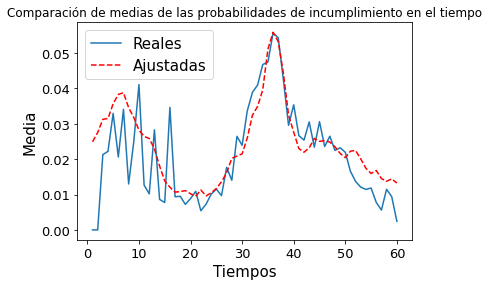

In [267]:
grafica_medias(data2.PD_logit_model, data2.default_time, data2.time)

In [268]:
#Creamos una funcion para revisar la calidad del ajuste
def grafica_ajuste(fit, outcome , time, continuous=False):
    fitP=pd.DataFrame(data=fit)
    outcomeP=pd.DataFrame(data=outcome)
    timeP=pd.DataFrame(data=time)
    
    data_in = pd.concat([fitP, outcomeP, timeP], axis=1)
    data_in.columns = ['fit', 'outcome', 'time']
    
    data_in['cat'] = pd.qcut(data_in.fit, 10, labels=False, duplicates='drop')
    real_fit = data_in.groupby('cat')[['fit', 'outcome']].mean()
    mpv=real_fit.fit.values
    fop=real_fit.outcome.values
    
    maximum=np.maximum(max(fop), max(mpv))       
    maximum=np.ceil(maximum*100)/100
    minimum=np.minimum(min(fop), min(mpv))
    minimum=np.floor(minimum*100)/100
    
    plt.title('Revisión de calibración')
    plt.plot(mpv, fop, marker='.', linestyle='', markersize=20)
    plt.plot([minimum,maximum],[minimum,maximum], linestyle='--', color='gray')
    plt.xlim((minimum,maximum))
    plt.ylim((minimum,maximum))
    plt.xlabel('Media de las pdś ajustadas', fontsize=15)
    plt.ylabel('Media da las pds reales', fontsize=15)
    plt.tick_params(axis='both', labelsize=13)
    plt.show()    
    
    

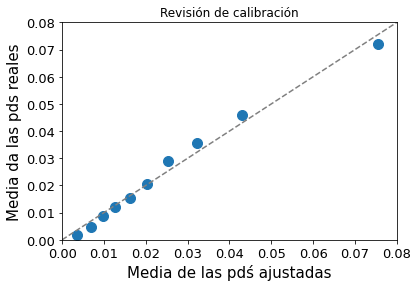

In [269]:
grafica_ajuste(data2.PD_logit_model, data2.default_time, data2.time)

In [270]:
# 2. PCA El analisis de componentes principales se hará para ejemplificar la reduccion de dimensionalidad con PCA
# La variable de estado tiene los siguientes valores:
data.state_orig_time.unique()

array(['KY', 'CO', 'GA', 'TN', 'CA', 'AL', 'NJ', 'DC', 'NC', 'NY', 'FL',
       'WA', 'MD', 'AZ', 'SC', 'MN', 'TX', 'VA', 'OH', 'CT', 'ME', 'MI',
       'WI', 'PA', 'OK', 'NV', 'MA', 'LA', 'IL', 'NE', 'ND', 'MO', 'MT',
       'AR', 'OR', 'NM', 'UT', 'IA', 'SD', 'ID', 'HI', 'RI', 'IN', 'WV',
       'VT', 'MS', 'NH', 'DE', 'KS', 'WY', 'PR', 'AK'], dtype=object)

In [271]:
# Una forma de incorporar esta variable es construir dummies con valores de 0 y 1 esto implicaría tener más de 50 variables
# Sin embargo podemos reducir dimensionalidad con el análisis de PCA
# Primero calcularemos las probabilidades de default de esta vaariable porque es lo que queremos ajustar.

defaultrates_states1 = data.groupby(['time','state_orig_time'])['default_time'].mean().unstack(level=1).add_prefix('defaultrate_').fillna(0).reset_index(drop=False)

In [272]:
# Ahora estandarizamos estos datos  y los ponemos en una matriz
scaler = StandardScaler()
defaultrates_states = scaler.fit_transform(defaultrates_states1)

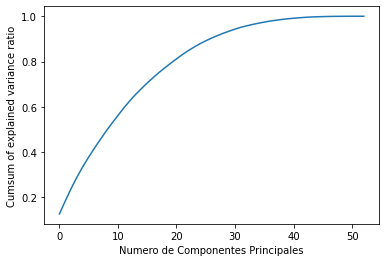

In [273]:
#Graficamos el aporte en varianza de cada componente pricipal adicional
pca=PCA()
pca.fit(defaultrates_states)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Numero de Componentes Principales')
plt.ylabel('Cumsum of explained variance ratio')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

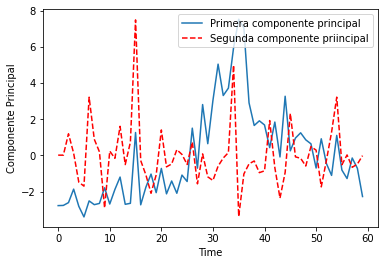

In [274]:
z = pca.transform(defaultrates_states)
plt.xlabel('Time')
plt.ylabel('Componente Principal')
plt.plot(defaultrates_states1.index, z[:,0], alpha =1, label = "Primera componente principal")
plt.plot(defaultrates_states1.index, z[:,1], alpha =1, color = 'red', linestyle = 'dashed', label = "Segunda componente priincipal")
plt.legend(loc='best')
plt.show

In [275]:
# Agregamos las 2 primmeras componentes principales a la base de datos
z = z[:,0:2]
Z = pd.DataFrame(data=z, columns=['PCA1', 'PCA2'])
Z_1 = Z.shift(1).add_suffix('_1')
defaultrates_states2 = pd.concat([defaultrates_states1['time'], Z_1], axis=1).dropna(subset=['PCA1_1']).copy() 
data_con_pca = pd.merge(data, defaultrates_states2, on='time')
data_con_pca

,id,time,orig_time,first_time,mat_time,res_time,balance_time,LTV_time,interest_rate_time,rate_time,...,Interest_Rate_orig_time,state_orig_time,hpi_orig_time,default_time,payoff_time,status_time,lgd_time,recovery_res,PCA1_1,PCA2_1
0,4,25,-2,25,119,NaN,61031.10,33.911009,10.500,5.90,...,10.500,KY,97.99,0,0,0,NaN,NaN,-2.091759,0.319049
1,9,25,18,25,138,NaN,127156.28,65.642484,8.730,4.14,...,8.730,GA,186.91,0,0,0,NaN,NaN,-2.091759,0.319049
2,47,25,19,25,139,NaN,130286.14,66.793811,6.930,4.24,...,6.930,TN,191.42,0,0,0,NaN,NaN,-2.091759,0.319049
3,13,25,18,25,138,NaN,228957.49,65.211476,7.560,4.14,...,7.560,MN,186.91,0,0,0,NaN,NaN,-2.091759,0.319049
4,35,25,19,25,139,NaN,78586.07,66.810457,7.030,4.24,...,7.030,TX,191.42,0,0,0,NaN,NaN,-2.091759,0.319049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61780,37843,15,13,15,73,NaN,44042.18,62.876322,5.125,3.54,...,5.125,OK,149.70,0,0,0,NaN,NaN,-2.702444,-0.504520
61781,38271,15,9,12,129,NaN,638742.73,57.759641,5.750,4.86,...,5.750,CA,132.76,0,0,0,NaN,NaN,-2.702444,-0.504520
61782,38752,15,11,15,131,NaN,333958.30,65.428152,6.000,3.83,...,6.000,MD,142.18,0,0,0,NaN,NaN,-2.702444,-0.504520
61783,39221,15,8,12,128,NaN,471428.67,43.327570,6.250,5.42,...,6.250,CA,125.92,0,0,0,NaN,NaN,-2.702444,-0.504520


In [276]:
# Ahora ajustamos la regresion logistica incluyendo PCA 1 y PCA 2 y las variables con mejor p values

model_lr_pca = smf.glm('default_time ~ balance_time + LTV_time + interest_rate_time + hpi_time + gdp_time + uer_time + REtype_PU_orig_time + investor_orig_time + balance_orig_time + FICO_orig_time + LTV_orig_time + Interest_Rate_orig_time + hpi_orig_time+ PCA1_1 + PCA2_1', family = sm.families.Binomial(), data = data_con_pca).fit()
print(model_lr_pca.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           default_time   No. Observations:                61785
Model:                            GLM   Df Residuals:                    61769
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6614.0
Date:                Mon, 07 Dec 2020   Deviance:                       13228.
Time:                        11:47:47   Pearson chi2:                 5.74e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [277]:
# Se aplica el modelo a la base
PD_logit_model_pca = pd.DataFrame(model_lr_pca.fittedvalues, columns=['PD_logit_model'])
# Hacemos una tabla con default o no default para cada tiempo que estamos estimando y su respectiva probabilidad
data3 = pd.merge(data_con_pca[['default_time','time']],PD_logit_model_pca, right_index=True, left_index=True)


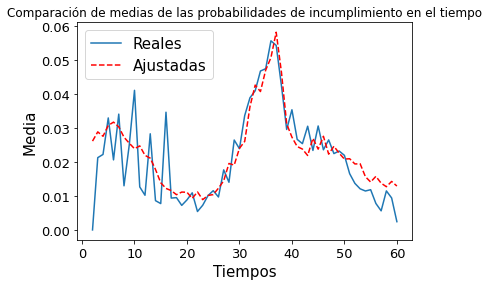

In [278]:
# Vemos nuestras graficas de ajuste
grafica_medias(data3.PD_logit_model, data3.default_time, data3.time)

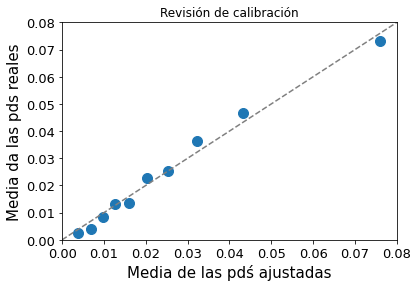

In [279]:
grafica_ajuste(data3.PD_logit_model, data3.default_time, data3.time)